# ART Boundary Attack

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
sys.path.append("..")

%matplotlib inline

import imagenet_stubs
import numpy as np
import keras
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import BoundaryAttack
from art.utils import to_categorical

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-8qzt1aqk
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-8qzt1aqk
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=795504 sha256=41132204c18162d928acc85f8298341040e2ec11c85ba8f3b531991cc3dd2a75
  Stored in directory: /tmp/pip-ephem-wheel-cache-oel8spkb/wheels/64/e6/a3/53e4a13354406428112f1ae250f746f879b8e9ab55397fa2d1
Successfully built imagenet-stubs
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Using TensorFlow backend.


# Model Definition

In [2]:
mean_imagenet = np.zeros([224, 224, 3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)
model = ResNet50(weights='imagenet')
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet, np.ones([224, 224, 3])))

102858752/102853048 [==============================] - 3s 0us/step


# Get Target and Init Images

Target image is:  105


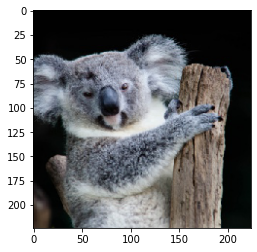

Init image is:  866


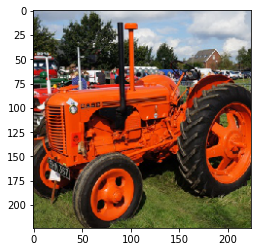

In [3]:
target_image_name = 'koala.jpg'
init_image_name = 'tractor.jpg'
for image_path in imagenet_stubs.get_image_paths():
    if image_path.endswith(target_image_name):
        target_image = image.load_img(image_path, target_size=(224, 224))
        target_image = image.img_to_array(target_image)
    if image_path.endswith(init_image_name):
        init_image = image.load_img(image_path, target_size=(224, 224))
        init_image = image.img_to_array(init_image)

print("Target image is: ", np.argmax(classifier.predict(np.array([target_image[..., ::-1]]))[0]))
plt.imshow(target_image.astype(np.uint))
plt.show()
print("Init image is: ", np.argmax(classifier.predict(np.array([init_image[..., ::-1]]))[0]))
plt.imshow(init_image.astype(np.uint))
plt.show()

# Boundary Untargeted Attack



Adversarial image at step 0. L2 error 42793.52 and class label 852.


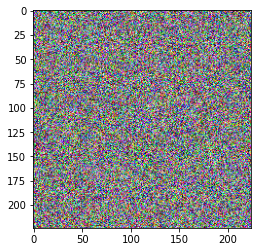



Adversarial image at step 2. L2 error 42686.61 and class label 852.


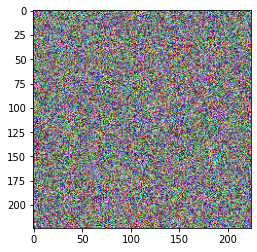

In [7]:
attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 2
x_adv = None
for i in range(2):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), x_adv_init=x_adv)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

# Boundary Targeted Attack

In [ ]:
attack = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.001, epsilon=0.001)
iter_step = 200
x_adv = np.array([init_image[..., ::-1]])

for i in range(20):
    x_adv = attack.generate(x=np.array([target_image[..., ::-1]]), y=to_categorical([866], 1000), x_adv_init=x_adv)

    #clear_output()    
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image[..., ::-1], [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0][..., ::-1].astype(np.uint))
    plt.show(block=False)
    
    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step 
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

# Unsquared Images

Boundary attack supports inputs of unsquared images. The code in the following cell describes an example of creating a Resnet50-based classifier to attack unsquared images.

```python
# Adjust image shape here
image_shape = (224, 150)

mean_imagenet = np.zeros(tuple(list(image_shape) + [3]))
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)

model = ResNet50(weights='imagenet', input_shape=tuple(list(image_shape) + [3]), include_top=False)

def _kr_initialize(_, dtype=None):
    return k.variable(value=np.random.randn(np.prod(list(model.output.shape)[1:]).value, 1000))

head = model.output
head = Flatten()(head)
head = Dense(1000, kernel_initializer=_kr_initialize, bias_initializer=keras.initializers.Zeros())(head)
new_model = Model(inputs=model.input, outputs=head)

classifier = KerasClassifier(clip_values=(0, 255), model=new_model, preprocessing=(mean_imagenet, 1))
# Then call classifier.fit() to train the new weights
```